# Runge-Kutta methods


## Introduction

For convenience, we start with importing some modules needed below:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('../styles/mainstyle.use')

In the previous notebook we have considered the forward and the backward Euler schemes to time march ordinary differential equations. We have discussed the concept of stability and estimated the accuracy of numerical schemes with respect to the size of the time step.

Here we introduce some more accurate methods with larger domains of stability, that are, therefore, applicable in more complex situations. We only consider systems of first-order differential equations as problems containing higher-order derivatives may be reduced to such systems. Our system of equations thus reads,

```{math}
    y'(t)=f(t,y)
```

where $y$ and $f$ are vector valued functions.

## A two-stage Runge-Kutta scheme

The forward Euler method is defined through:

```{math}
:label: eq:ForwardEuler3
y^{n+1} \equiv y^n + f(t^n,y^n) dt \;\;\;\; (\textrm{Forward Euler method}),
```

with all the intermediate times denoted $t^n = t_0+ndt$, and the corresponding values of $y(t)$ as $y^n = y(t^n)$.

Graphically, we see that $y^{n+1}$ is evaluated using the value $y^n$ and the slope (derivative) of $y$ at time $t^n$:

<img src="../figures/Euler.png" align="center" width="500">

Runge-Kutta schemes increase the accuracy of the estimated value $y^{n+1}$ by introducing intermediate times between $t^n$ and $t^{n+1}$, at which the derivative of $y$ is evaluated and by making use of this information.

The following two-stage Runge-Kutta method is the simplest of such schemes. Graphically, this scheme is defined as follows:

<img src="../figures/RK2.png" align="center" width="500">

so that,

```{math}
:label: RK2ynp1
    y^* = y^n +\frac{dt}{2}f(t^n, y^n) \\
    y^{n+1} = y^n + dt f(t^n+\frac{dt}{2},y^*)
```

In notebook 1.1, we discussed the fact that the forward Euler method is second-order accurate for one time step and first-order accurate for a complete time interval. Here, we hope to improve the accuracy. Let's check that this is true by evaluating the Taylor expansion of $y^{n+1}$ in {eq}`RK2ynp1`.

```{math}
:label: TaylorRK2
 y^{n+1} & = y^n + dt f(t^n+\frac{dt}{2},y^n + \frac{dt}{2}f(t^n, y^n)) \nonumber \\
         & = y^n + dt \left[ f(t^n, y^n) + \frac{dt}{2} \partial_t f(t^n, y^n) + \frac{dt}{2} f(t^n, y^n)\partial_y f(t^n,y^n)\\
         + \frac{dt^2}{8} \partial_{tt} f(t^n, y^n) + \frac{dt^2}{4} f(t^n, y^n) \partial_{yt} f(t^n, y^n) + \frac{dt^2}{8} f^2(t^n, y^n) \partial_{yy} f(t^n, y^n) + O(dt^3) \right] \nonumber \\
         & = y^n + dt y'^n + \frac{dt^2}{2}y''^n + O(dt^3),
```

where we have used the property: $y''=\partial_t f + f\partial_y f$. Combined with the fact that $y''' = \partial_{tt} f + 2f\partial_{yt}f + f^2 \partial_{yy} f + \partial_t f \partial_y f + f (\partial_y f)^2$, the last equation proves that the two-stage Runge-Kutta method is of third order for one time step. As a consequence, it is also in general second-order accurate for a complete time interval.

### Numerical stability of a two-stage Runge-Kutta scheme

Let us now discuss the stability of this two-stage Runge-Kutta method for a general autonomous linear system of differential equations. As usual, we may diagonalize the system defined through the matrix $f$ and write:

```{math}
    z' = \Lambda z,
```

where $\Lambda$ is the diagonal matrix composed of the eigenvalues $\lambda_k$ of $f$, and $z$ are the coordinates of $y$ in the eigenbasis.

Using the two-stage Runge-Kutta scheme, we then have,

```{math}
    z^{n} = (I+ dt \Lambda + \frac{dt^2}{2}\Lambda^2) z^{n-1} \; \Leftrightarrow \; z^{n} = (I+ dt \Lambda + \frac{dt^2}{2}\Lambda^2)^n z^0.
```

All the components of $z^{n}$ will remain finite for $n\rightarrow \infty$ as long as the following relation is satisfied for all the eigenvalues $\lambda_k$:

```{math}
    \vert 1+\lambda_k dt + \frac{\lambda_k^2 dt^2}{2} \vert \leq 1.
```

Let us apply the Runge-Kutta scheme to the problem of a body in free fall. The system of differential equations reads:

```{math}
    \begin{cases}
    & \displaystyle \frac{dh}{dt}=v,\\
    & \displaystyle \frac{dv}{dt}=-g.
    \end{cases}
```

Rephrasing it in matrix form we get:

```{math}
\frac{d}{dt}
\begin{pmatrix}
    h \\
    v
\end{pmatrix}
=
& \begin{pmatrix}
    0 & 1 \\
    0 & 0
\end{pmatrix}
\begin{pmatrix}
    h \\
    v
\end{pmatrix}
+
\begin{pmatrix}
    0 \\
    -g
\end{pmatrix}
\nonumber
```

```{math}
:label: eq:free_fall
\Leftrightarrow
\frac{dy}{dt} = Ly + b
```


with $y=(h\;\; v)$, $b=(0\;\; -g)$ and, obviously,

```{math}
L=
\begin{pmatrix}
    0 & 1 \\
    0 & 0
\end{pmatrix}.
```

As $L$ and $b$ are constant, the two-stage Runge-Kutta scheme applied to {eq}`eq:free_fall` becomes:
1. $\displaystyle y^* = y^n + \frac{dt}{2} (Ly^n+b),$
2. $\displaystyle y^{n+1} = y^n + dt(Ly^*+b).$

Let's implement this procedure.

In [2]:
g = 9.81  # ms^-2, gravitational constant
h0 = 100. # m, initial height
v0 = 0.   # ms^-1, initial speed

ti = 0.   # s, initial time
tf = 4.0  # s, final time at which to seek the solution
dt = 0.1  # s, time step

In [3]:
nt = int((tf-ti)/dt)

# Create a numpy array to contain the
# intermediate values of y, including
# those at ti and tf.
y = np.empty((nt+1, 2))

# Store initial condition in y[0].
y[0] = h0, v0

# Create vector b.
b = np.array([0., -g])

# Create matrix L.
L = np.array([[0., 1.], [0., 0.]])

# Perform the two-stage time stepping.
for i in range(nt):
    y_star = y[i] + 0.5*dt*(np.dot(L, y[i])+b)
    y[i+1] = y[i] + dt*(np.dot(L, y_star)+b)

In [4]:
# array for the time interval data
t = np.arange(nt+1) * dt

We visualize the solution:

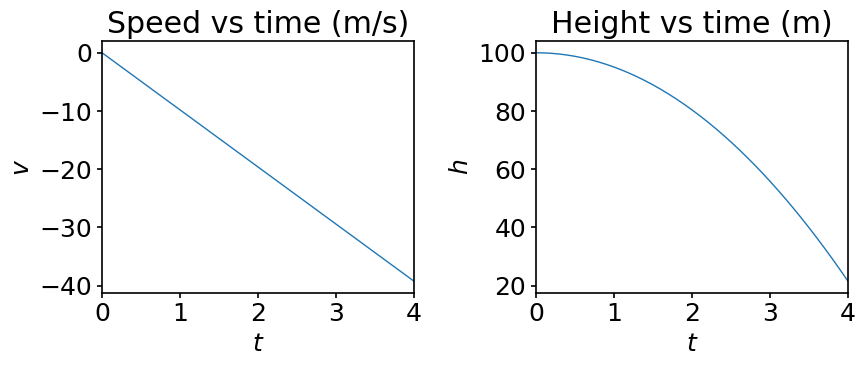

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

ax[0].plot(t, y[:, 1])

ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$v$')
ax[0].set_title('Speed vs time (m/s)')

ax[1].plot(t, y[:, 0])

ax[1].set_xlabel('$t$')
ax[1].set_ylabel('$h$')
ax[1].set_title('Height vs time (m)')

# Let us bind the axes to the relevant
# interval.
for axis in ax:
    axis.set_xlim(t[0], t[-1])

## General Runge-Kutta schemes

General Runge-Kutta schemes are defined as follows {footcite}`Hairer1987`:

```{math}
:label: eq:rk_gen_exp
 y^{n+1} &= y^n + dt(b_1 k_1 + \cdots + b_s k_s) \nonumber \\
 k_1 & = f(t^n, y^n) \nonumber \\
 k_2 & = f(t^n + c_2 dt, y^n + dta_{21}k_1) \nonumber \\
 k_3 & = f(t^n + c_3 dt, y^n + dt(a_{31}k_1+a_{32}k_2)) \nonumber \\
 & \cdots \nonumber \\
 k_s & = f(t^n + c_s dt, y^n + dt(a_{s1}k_1+\cdots + a_{s,s-1}k_{s-1}))
```

Some constraints are then put on all the coefficients to achieve a given order of accuracy $O(dt^p)$ for $y^{n+1}$. One says that the $s$-stage Runge-Kutta method is of order $p$.

The construction of higher order Runge-Kutta schemes is in fact quite complicated, and has been the subject of a vast literature (some in-depth review of the Runge-Kutta methods may be found in {footcite}`Butcher2008` or {footcite}`Hairer1987`). There is no systematic way to obtain order $p$ methods with a minimum number of stages $s$. One can achieve order $p$ with $s=p$ up to $p=4$. For $p=5$ and $p=6$ one needs at least $s=p+1$ stages. For $p=7$ and $p=8$ the minimum number of stages are respectively $s=9$ and $s=11$.

> Above this, very little is known {footcite}`Butcher1996`.

Therefore, we focus here our attention on a general purpose **fourth-order Runge-Kutta scheme**, that is accurate and stable enough for all the problems we consider in the rest of this course (from now on we call it **RK4**). It was introduced in 1901 by W. Kutta and reads {footcite}`Kutta1901`:

```{math}
    y^{n+1} & = y^n + \frac16 k_1 + \frac13(k_2 + k_3) + \frac16 k_4 \nonumber \\
    k_1 & = dtf(t^n,y^n) \\
    k_2 & = dtf(t^n+\frac{dt}{2},y^n+\frac12 k_1) \\
    k_3 & = dtf(t^n+\frac{dt}{2},y^n+\frac12 k_2) \\
    k_4 & = dtf(t^n+dt,y^n+k_3)
```

For an autonomous linear system, it is straightforward to prove that this method is indeed fifth-order accurate for one time step. After diagonalization, we have:

```{math}
  z^{n+1} & = z^n + \frac16 dt \Lambda z^n + \frac13 dt \Lambda (z^n + \frac12 dt \Lambda z^n ) + \frac13 dt \Lambda (z^n + \frac12 dt \Lambda (z^n + \frac12 dt \Lambda z^n)) \nonumber \\
   & +\frac16 dt \Lambda (z^n + dt \Lambda (z^n + \frac12 dt \Lambda (z^n + \frac12 dt \Lambda z^n))) \nonumber \\
  & = z^n + dt \Lambda z^n + \frac{dt^2}{2}\Lambda^2 z^n + \frac{dt^3}6 \Lambda^3 z^n + \frac{dt^4}{24} \Lambda^4 z^n
```

The last expression coincides with the Taylor expansion of $z^{n+1}$ up to fourth order. For a non-linear system, one can also prove that RK4 is of fourth order but it is a tedious task.

In terms of stability, we also see that the RK4 method is stable for a general autonomous linear system as long as all the eigenvalues of the operator $f$ satisfy,

```{math}
    \vert 1+\lambda_k dt + \frac{\lambda_k^2 dt^2}{2} + \frac{\lambda_k^3 dt^3}{6} + \frac{\lambda_k^4 dt^4}{24}\vert \leq 1.
```

In the following plot, we compare the regions of stability for the various schemes we have already discussed.

In [6]:
# As before, the x-axis corresponds to
# lambda_r*dt and the y-axis to lambda_i*dt.
# We set the resolution along x and y
# (in points per the whole 1D domain).
nx = 100
ny = 100

In [7]:
# We create numpy arrays, which store the
# x-points and the y-points.
# numpy.linspace is another way to create a
# numpy array for a sequence of numbers
# in some range, alternatively to numpy.arange.
# We must pass starting and end points to
# the linspace function. Unlike the arange
# function, here we set number of points
# we want to put between, instead of the
# distance between the points.
# Also note that, while numpy.arange does
# NOT include the end point you pass into
# the array, linspace does include it.
#
# For more info
# https://numpy.org/doc/stable/reference/generated/numpy.linspace.html
x = np.linspace(-3.5, 1.5, nx)
y = np.linspace(-3.5, 3.5, ny)

# The purpose of numpy.meshgrid can be
# pretty much assumed from the name of the
# function. meshgrid creates the ND coor-
# dinate arrays from the 1D sets of coor-
# dinates. In more simple words, when you
# pass, for example, two 1D arrays, repre-
# senting the coordinates along two axes,
# meshgrid returns two 2D arrays. The first
# one contains x-coordinates for each
# gridline drawn parallel to x-axis, and
# the second one contains y-coordinates
# for each gridline drawn parallel to
# y-axis, respectively.
#
# For more info
# https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html?highlight=meshgrid
X, Y = np.meshgrid(x, y)

# Go to the space of complex numbers.
Z = X + 1j*Y

# Terms remaining from Taylor expansion for
# the Euler scheme.
sigma1 = 1 + Z

# We compute the norm of sigma1.
norm1 = np.real(sigma1*sigma1.conj())

# Terms remaining from Taylor expansion for
# the RK2.
sigma2 = 1 + Z + Z**2/2.

norm2 = np.real(sigma2*sigma2.conj())

# Terms remaining from Taylor expansion for
# the RK4.
sigma4 = 1 + Z + Z**2/2. + Z**3/6. + Z**4/24.

norm4 = np.real(sigma4*sigma4.conj())

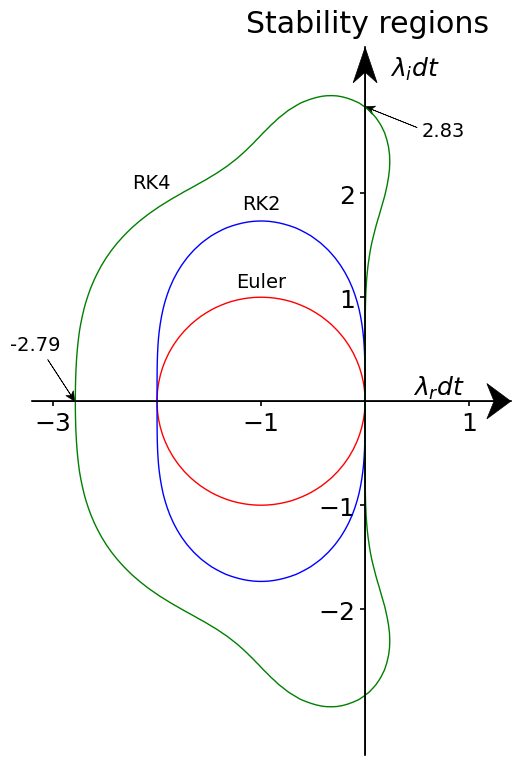

In [8]:
fig, ax = plt.subplots(figsize=(8,8))

# We shall now use the
# matplotlib.pyplot.contour function.
# As X and Y, we pass the mesh data. Let
# f(x, y)=g(x, y) + C be some function
# where C is a constant. Imagine
# we want to plot contour lines for the
# set of integer values of C=0,-1,-2,-3,...
# They will be described by equations
# g(x, y) = 0, g(x, y) = 1, g(x, y) = 2,...
#
# That's what the contour function does.
# For example, if given the equation of
# circle, contour function will plot the
# contour lines for (x-a)^2+(y-b)^2=0,1,2,...
#
# For more info
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html
#
# matplotlib.pyplot.contour provides us
# exactly the tool we want, as our condi-
# tion for stability is given by an expression
# of the kind f(x, y) <= 1. The only thing we
# have to do is to display o n l y that contour line
# which corresponds to C=-1.
#
# When passing certain levels to the contour
# function, the datatype must be either a single
# integer, or a sequence of integers (list,
# tuple, numpy.ndarray...). When contours at
# certain levels are of interest, then we must
# use an array-like object.
ax.contour(X, Y, norm1, levels=[1], colors='r')
ax.contour(X, Y, norm2, levels=[1], colors='b')
ax.contour(X, Y, norm4, levels=[1], colors='g')

ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('center')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

xmin, xmax = -3.2, 1.4
ymin, ymax = -3.4, 3.4

ax.set_xlim(xmin ,xmax)
ax.set_ylim(ymin, ymax)

ax.arrow(xmin, 0., xmax-xmin, 0., fc='k', ec='k', lw=0.5,
         head_width=1./20.*(ymax-ymin), head_length=1./20.*(xmax-xmin),
         overhang = 0.3, length_includes_head= True, clip_on = False)

ax.arrow(0., ymin, 0., ymax-ymin, fc='k', ec='k', lw=0.5,
         head_width=1./20.*(xmax-xmin), head_length=1./20.*(ymax-ymin),
         overhang = 0.3, length_includes_head= True, clip_on = False)

ax.yaxis.set_label_coords(0.85, 0.95)
ax.xaxis.set_label_coords(1.05, 0.475)

ax.set_xticks((-3, -1, 1))
ax.set_yticks((-2, -1, 1, 2))

# Label contours
ax.text(-1, 1.1, r'Euler', fontsize=14, horizontalalignment='center')
ax.text(-1, 1.85, r'RK2', fontsize=14, horizontalalignment='center')
ax.text(-2.05, 2.05, r'RK4', fontsize=14, horizontalalignment='center')

# Notable points
ax.arrow(0.5, 2.63, -0.5, 0.2, fc='k', ec='k', lw=0.5,
         head_width=1./80.*(ymax-ymin), head_length=1./50.*(xmax-xmin),
         overhang = 0.3, length_includes_head= True, clip_on = False)
ax.text(0.75, 2.55, r'2.83', fontsize=14, horizontalalignment='center')

ax.arrow(-3.05, 0.4, 0.26, -0.4, fc='k', ec='k', lw=0.5,
         head_width=1./80.*(ymax-ymin), head_length=1./50.*(xmax-xmin),
         overhang = 0.3, length_includes_head= True, clip_on = False)
ax.text(-3.17, 0.49, r'-2.79', fontsize=14, horizontalalignment='center')

# Axis labels
ax.set_xlabel(r'$\lambda_i dt$')
ax.xaxis.set_label_coords(0.8, 0.99)
ax.set_ylabel(r'$\lambda_r dt$', rotation=0)
ax.yaxis.set_label_coords(0.85, 0.5)

ax.set_aspect(1)

ax.set_title('Stability regions', x=0.7, y=1.01);

# fig.savefig('../figures/stabilityDomains.png', dpi=300)

We already pointed out that the forward Euler scheme is unstable if one of the eigenvalues of our system is purely imaginary (as in the case of the harmonic oscillator). Although the RK2 scheme's domain of stability is larger, the scheme has the same property. Of all the schemes considered so far, RK4 has a significantly larger domain of stability and, more importantly, it does englobe a part of the imaginary axis, so, it can handle problems with purely imaginary eigenvalues!

## Implicit Runge-Kutta schemes

We have discussed that explicit Runge-Kutta schemes become quite complicated as the order of accuracy increases. Implicit Runge-Kutta methods might appear to be even more of a headache, especially at higher-order of accuracy $p$. We will give a very brief introduction into the subject, so that you get an impression.

Generally speaking, RK methods can be defined as follows:

```{math}
& y^{n+1} = y^n + dt\sum_{i}^{s} b_i k_i,\nonumber\\
& k_i = f(t^n + c_i dt, y^n + dt\sum_{j=1}^h a_{ij} k_j).
```

For explicit RK methods one has $h=s-1$. This implies that any $k_i$ can be computed explicitly from the knowledge of the previously computed $k_j$ with $j<i$. For implicit RK methods, we have $h=s$. It mean, that for each $k_i$ we have to solve an implicit equation $k_i=f(k_1, k_2,\dots,k_i)$. We pay a price in terms of complexity (we have to invert some matrix or iteratively find a solution to the previous equation). However, implicit RK methods have better stability properties compared to explicit ones and can therefore be used for a larger set of problems.

As an example, let us consider some relatively simple implicit RK scheme - we went on [Wikipedia][1] and picked one named *Qin and Zhang's two-stage second-order* implicit method. It reads:

```{math}
y^{n+1} &= y^n + \frac{1}{2}(k_1 + k_2),\nonumber \\
k_1 &= f(t^n+\frac{dt}{4}, y^n+\frac{dt}{4}k_1),\nonumber \\
k_2 &= f(t^n+\frac{3}{4}dt, y^n+dt(\frac{1}{2}k_1+\frac{1}{4}k_2)).
```

Let's implement it for the problem of a body in free fall described by {eq}`eq:free_fall`. Make sure you understand the implementation of the implicit scheme in the code...

[1]: <https://en.wikipedia.org/wiki/List_of_Runge–Kutta_methods> "list of RK"

In [9]:
g = 9.81  # ms^-2, gravitational constant
h0 = 100. # m, initial height
v0 = 0.   # ms^-1, initial speed

ti = 0.   # s, initial time
tf = 10.0 # s, final time at which to seek the solution
dt = 0.5  # s, time step

In [10]:
nt = int((tf-ti)/dt)

# Create numpy arrays to contain the
# intermediate values of y
y_exp = np.empty((nt+1, 2)) # Explicit RK2
y_imp = np.empty((nt+1, 2)) # Implicit RK2

# Store initial condition in y[0, :].
y_exp[0] = h0, v0
y_imp[0] = h0, v0

# Create vector b.
b = np.array([0., -g])

# Create matrix L.
L = np.array([[0., 1.], [0., 0.]])

# Compute the constant matrix needed in
# the implement implicit RK scheme.
# numpy.eye returns a unity matrix.
# The argument defines the shape of the matrix.
# There is a possibility to shift the dia-
# gonal if needed.
#
# For more info
# https://numpy.org/doc/stable/reference/generated/numpy.eye.html
mat_k = np.linalg.inv(np.eye(2)-L*dt/4.)

# Perform the time stepping according to
# both explicit and implicit schemes in
# one loop.
for i in range(nt):
    # Explicit time stepping
    y_star = y_exp[i] + 0.5*dt*(np.dot(L, y_exp[i])+b)
    y_exp[i+1] = y_exp[i] + dt*(np.dot(L, y_star)+b)

    # Implicit scheme time stepping.
    k_1 = np.dot(mat_k, np.dot(L, y_imp[i])+b)
    k_2 = np.dot(mat_k, np.dot(L, y_imp[i]+k_1*dt/2.)+b)
    y_imp[i+1] = y_imp[i] + 0.5*dt*(k_1+k_2)

Let's now plot our solution:

In [11]:
t = np.arange(nt+1) * dt

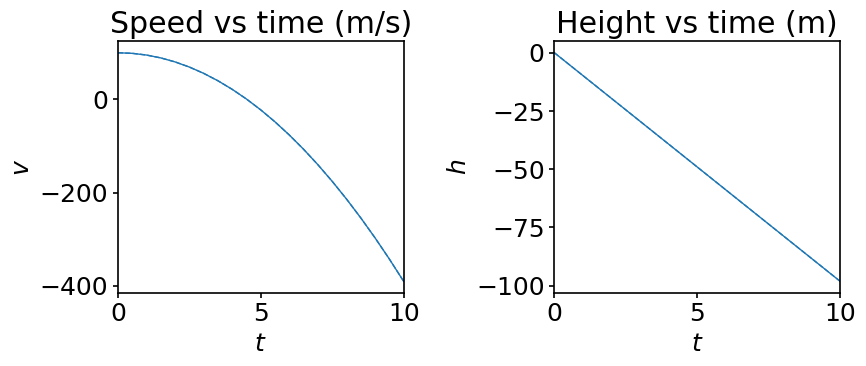

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))

ax[0].plot(t, y_exp[:, 0], '--')
ax[0].plot(t, y_imp[:, 0], '-')

ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$v$')
ax[0].set_title('Speed vs time (m/s)')

ax[1].plot(t, y_exp[:, 1], '--')
ax[1].plot(t, y_imp[:, 1], '-')

ax[1].set_xlabel('$t$')
ax[1].set_ylabel('$h$')
ax[1].set_title('Height vs time (m)')

# Let us bind the axes to the relevant
# interval.
for axis in ax:
    axis.set_xlim(t[0], t[-1])

## Summary

In this notebook we have introduced a family of Runge-Kutta explicit and implicit methods. While we won't consider Runge-Kutta schemes of order higher than 4 in the course, we discussed the complexities one would face trying to construct equations for the coefficients $k_i$ for higher-order schemes. We also gave insight into implicit Runge-Kutta schemes and provided an implementation of Qin and Zhang's second-order implicit method.

With this we conclude the chapter dedicated to **time integration**. In the following chapter we will consider the finite differences method to approximate derivatives in partial differential equations and convert them into a system of linear equations.

## References
```{footbibliography}
```